# Flights & Ads - Analyzing, Querying, Cleaning & Performing ML
## Using PySpark (ml, sql) and ETL integrations  with AWS S3, mySQL 
<p>We'll use open source data pertaining to Flights and Advertisements.</p>

The Approach:
<p> Part One: Decision Tree, Random Forest & S3 </p>
<li>Store data in an Amazon S3 Bucket, and import all necessary libraries </li>
<li>Explore our data using PySpark and make visualizations using Pandas and MatPlotLib/Seaborn. </li>
<li>Prepare data for ML, Create a Decision Tree Classifier and Score it. </li>
<li>Create a Random Forest Classifier, pipeline and fit to our Advertising Data. </li>
<li>Push our predictions dataframe back into S3 programatically.</li>

<p> Part Two: K-Means Clustering, PCA, S3 & mySQL </p>
<li>Store our in an Amazon S3 Bucket, explore and clean data </li>
<li>Prepare data for ML, create KMeans Object and fit them our Flights Data. </li>
<li>Optimize our model using hyperparameter tuning </li>
<li>Visualize our clusters. </li>
<li>Push our predictions dataframe into a mySQL database.</li>
</ul>

## Part One: Decision Tree, Random Forest & S3
### a) Store data in an Amazon S3 Bucket, and import all necessary libraries

In [1]:
#Initialize
#import findspark
#findspark.init()

In [2]:
#Import Libraries for Part 1

#Initial
import os
import json
import pyspark
from pyspark.sql import SparkSession

#Graphing and exploration
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

#ML Preprocessing
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import StringIndexer, IndexToString

#ML Models, Pipeline, evaluators
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


In [3]:
#Import Libraries for Part 2

#Cleaning
from pyspark.sql.functions import round as rounded

#Preprocessing, ML Models, Evaluators
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

#Hyperparameter Tuning
from pyspark.ml import tuning as tune

#SQL
import mysql.connector

In [4]:
#Set environ using apache aws package
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.hadoop:hadoop-aws:2.7.3 pyspark-shell'
#os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#os.environ["SPARK_HOME"] = "C:\Users\saisu\Desktop\spark"

In [5]:
with open('rootkey.json') as file:
    data = json.load(file)
    access_key = data['AWS Keys']['AWSAccessKeyId']
    secret_key = data['AWS Keys']['AWSSecretKey']

In [6]:
#Import Secret and Access Keys
#change to vscode file
AWSAccessKeyId = access_key
AWSSecretKey = secret_key

In [7]:
#Create SparkContext
sc = pyspark.SparkContext("local[*]").getOrCreate()

In [8]:
#Get Hadoop Configuration Object 
hadoop_conf = sc._jsc.hadoopConfiguration()

In [9]:
#Set Hadoop Conf Settings

#Set s3a filesystem
hadoop_conf.set("fs.s3a.impl", "org.apache.hadoop.fs.s3native.NativeS3FileSystem")
#Set access key's
hadoop_conf.set("fs.s3a.awsAccessKeyId", AWSAccessKeyId)
hadoop_conf.set("fs.s3a.awsSecretAccessKey", AWSSecretKey)
#Buffer folder (Staging)
hadoop_conf.set("fs.s3.buffer.dir", '${hadoop.tmp.dir}/s3')
hadoop_conf.set("fs.s3a.buffer.dir", '${hadoop.tmp.dir}/s3a')
#Set Endpoint
hadoop_conf.set("fs.s3a.endpoint", "protocol://service-code.ca-central-1.amazonaws.com");


In [10]:
#Load File
df = sc.textFile("s3a://pyspark-ads-data/ads/Social_Network_Ads.csv")

In [11]:
df

s3a://pyspark-ads-data/ads/Social_Network_Ads.csv MapPartitionsRDD[1] at textFile at <unknown>:0

In [ ]:
#Resolve error
df.collect()

### b) Explore our data using PySpark and make visualizations using Pandas and MatPlotLib/Seaborn.

In [12]:
#initialize sql context
spark = SparkSession.builder.appName('advertising_classifiers').getOrCreate()

In [13]:
#Load using Spark SQL
df = spark.read.csv("Data/Social_Network_Ads.csv", header=True, inferSchema=True)

In [14]:
#Inspect first 5 rows
df.show(5)

+--------+------+---+---------------+---------+
| User ID|Gender|Age|EstimatedSalary|Purchased|
+--------+------+---+---------------+---------+
|15624510|  Male| 19|          19000|        0|
|15810944|  Male| 35|          20000|        0|
|15668575|Female| 26|          43000|        0|
|15603246|Female| 27|          57000|        0|
|15804002|  Male| 19|          76000|        0|
+--------+------+---+---------------+---------+
only showing top 5 rows



In [15]:
#Check dtypes
df.printSchema()

root
 |-- User ID: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- EstimatedSalary: integer (nullable = true)
 |-- Purchased: integer (nullable = true)



In [16]:
#Get Shape of our Data
print((df.count(), len(df.columns)))

(400, 5)


In [17]:
#Check for na's
for col in df.columns:
    if df.filter(df[col].isNull()).count() > 0:
        print(col)

In [18]:
#Begin Exploratory Analysis
#Investigate Correlation between Y & numerical X
print(df.corr('Purchased', 'Age'))
print(df.corr('Purchased', 'EstimatedSalary'))

0.6224541988845288
0.3620830258046777


In [19]:
#Two Categorical Variables
contigency_table = df.crosstab('Gender', 'Purchased')
contigency_table.show()

+----------------+---+---+
|Gender_Purchased|  0|  1|
+----------------+---+---+
|            Male|130| 66|
|          Female|127| 77|
+----------------+---+---+



In [20]:
chi_2, p_val, dof, expected_table = chi2_contingency([[130, 127], [66, 77]])
p_val

0.45624659183130645

In [21]:
#The benefit of pyspark is its clusters which allow for a lot of data
#This is just for practice but we will continue as if we have a lot more data
#Get a sample to visualize data

df_sample = df.sample(False, 0.3, 10).toPandas()

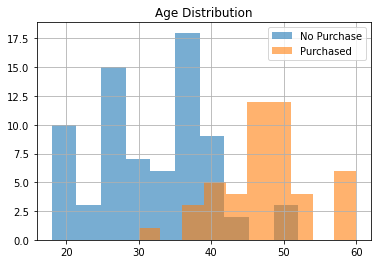

In [22]:
df_sample.Age[df_sample.Purchased == 0].hist(alpha=0.6, label='No Purchase')
df_sample.Age[df_sample.Purchased == 1].hist(alpha=0.6, label = 'Purchased')
plt.title('Age Distribution')
plt.legend()
plt.show()

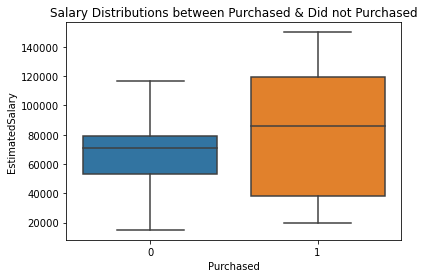

In [23]:
sns.boxplot(data=df_sample, x='Purchased', y='EstimatedSalary')
plt.title('Salary Distributions between Purchased & Did not Purchased')
plt.show()

### c) Prepare data for ML, Create a Decision Tree Classifier and Score it

In [24]:
df.show(2)

+--------+------+---+---------------+---------+
| User ID|Gender|Age|EstimatedSalary|Purchased|
+--------+------+---+---------------+---------+
|15624510|  Male| 19|          19000|        0|
|15810944|  Male| 35|          20000|        0|
+--------+------+---+---------------+---------+
only showing top 2 rows



In [25]:
#Split data
train_data, test_data = df.randomSplit([0.8, 0.2], seed=24)

In [26]:
#Prepare data for classification #From our analysis above we will use Salary & Income Features

#Instantiate Vector Assembler
vec_assem = VectorAssembler(inputCols=['Age', 'EstimatedSalary'], outputCol='features')

#Instantiate Scaler 
scaler = MinMaxScaler(inputCol='features', outputCol='features_scaled')

#indexer (y val) #we would normally use vectorindexer on our features with maxcat > 5, to index non-continuous features (since vec assembler is first)
#however we have only continuous features

indexer = StringIndexer(inputCol = 'Purchased', outputCol = 'indexedLabel').fit(train_data)
#indexer must be fit to use label_converter's labels
label_converter = IndexToString(inputCol= 'prediction', outputCol='predictedLabel', labels=indexer.labels)

In [27]:
#Instantiate Decision Tree Classifier #Default param is okay, max depth 5, gini impurity score etc.

dtc = DecisionTreeClassifier(featuresCol = 'features_scaled', labelCol='indexedLabel')

In [28]:
#Instantiate Pipeline
#Scaler does not handle multicol's so we'll assemble a vector first
#Scale, index, train our model, then convert our label back to the predicted class

dtc_pipeline = Pipeline(stages=[vec_assem, scaler, indexer, dtc, label_converter])

In [29]:
#Fit model to training data
model = dtc_pipeline.fit(train_data)

In [30]:
#Score model on testing data
pred = model.transform(test_data)
pred = pred.withColumn('predictedLabel', pred.predictedLabel.cast('double'))

In [31]:
#Instantiate Evaluator and Evaluate Model
evaluator = MulticlassClassificationEvaluator(predictionCol='predictedLabel', labelCol='Purchased')
evaluator.evaluate(pred)

0.9437562437562437

In [32]:
#Create Confusion Matrix & Calculate other metrics
matrix = pred.groupBy(['predictedLabel', 'purchased']).count().show()
TP = pred.filter('predictedLabel == purchased AND purchased == 1').count()
TN = pred.filter('predictedLabel == purchased AND purchased == 0').count()
FP = pred.filter('predictedLabel != purchased AND purchased == 0').count()
FN = pred.filter('predictedLabel != purchased AND purchased == 1').count()
print(f'True Positive\'s: {TP}')
print(f'True Negative\'s: {TN}')
print(f'False Positive\'s: {FP}')
print(f'False Negative\'s: {FN}')
print('\n')
print(f'Accuracy: {round((TP + TN)/(TP + TN + FP + FN), 2)}')
print(f'Recall: {round((TP)/(TP + FN), 2)}')
print(f'Precision: {round((TP)/(TP + FP), 2)}')

+--------------+---------+-----+
|predictedLabel|purchased|count|
+--------------+---------+-----+
|           1.0|        0|    4|
|           0.0|        0|   42|
|           1.0|        1|   24|
+--------------+---------+-----+

True Positive's: 24
True Negative's: 42
False Positive's: 4
False Negative's: 0


Accuracy: 0.94
Recall: 1.0
Precision: 0.86


### d) Create a Random Forest Classifier, pipeline and fit to our Advertising Data.

In [33]:
#Instantiate Random Forest Classifier #Default is fine 20 trees, auto/sqrt columns etc.
rf = RandomForestClassifier(featuresCol = 'features_scaled', labelCol='indexedLabel')

#Build new pipeline
rf_pipeline = Pipeline(stages=[vec_assem, scaler, indexer, rf, label_converter])

In [34]:
#Train and Score RF Model
rf_model = rf_pipeline.fit(train_data)

In [35]:
#Score model on testing data
pred = rf_model.transform(test_data)
pred = pred.withColumn('predictedLabel', pred.predictedLabel.cast('double'))

In [36]:
#Evaluate using same evaluator
evaluator.evaluate(pred)

0.9437562437562437

In [37]:
matrix = pred.groupBy(['predictedLabel', 'purchased']).count().show()
TP = pred.filter('predictedLabel == purchased AND purchased == 1').count()
TN = pred.filter('predictedLabel == purchased AND purchased == 0').count()
FP = pred.filter('predictedLabel != purchased AND purchased == 0').count()
FN = pred.filter('predictedLabel != purchased AND purchased == 1').count()
print(f'True Positive\'s: {TP}')
print(f'True Negative\'s: {TN}')
print(f'False Positive\'s: {FP}')
print(f'False Negative\'s: {FN}')
print('\n')
accuracy = round(float((TP + TN)/(TP + TN + FP + FN)), 2)
print(f'Accuracy: {accuracy}')
print(f'Recall: {round((TP)/(TP + FN), 2)}')
print(f'Precision: {round((TP)/(TP + FP), 2)}')
#Our dataset isn't really big enough to take advantage of a True Random Forest (tree's are identical to our DTC just multiple)
#E.g. subsamplingRate = 0.10 would yield diff accuracy (to simulate if tree's had different data each)

+--------------+---------+-----+
|predictedLabel|purchased|count|
+--------------+---------+-----+
|           1.0|        0|    4|
|           0.0|        0|   42|
|           1.0|        1|   24|
+--------------+---------+-----+

True Positive's: 24
True Negative's: 42
False Positive's: 4
False Negative's: 0


Accuracy: 0.94
Recall: 1.0
Precision: 0.86


### e) Push our predictions dataframe back into S3 programatically.

In [ ]:
#Solve error
pred.rdd.repartition(1).saveAsTextFile("s3a://pyspark-ads-data/ads/predictions_rdd")

In [ ]:
#Solve error
pred.write.csv('s3a://pyspark-ads-data/ads/Social_Network_Ads_predicted.csv')

## Part Two: K-Means Clustering, PCA, S3 & mySQL
### a) Store our in an Amazon S3 Bucket, import all necessary libraries, explore and clean data.

In [38]:
#Initial sql context
spark = SparkSession.builder.appName('flights_cluster').getOrCreate()

In [39]:
#Import Dataset
df = spark.read.csv('Data/airlines1.csv', header=True)
airline = df.select("Origin","Dest","AirTime","Distance")
airline.show(5)

+------+----+-------+--------+
|Origin|Dest|AirTime|Distance|
+------+----+-------+--------+
|   MSP| SLC|  153.0|   991.0|
|   MKE| MCO|  141.0|  1066.0|
|   GJT| DFW|  103.0|   773.0|
|   LAX| DTW|  220.0|  1979.0|
|   EWR| CLT|   80.0|   529.0|
+------+----+-------+--------+
only showing top 5 rows



In [40]:
#Dataset is heavy so we will cache is
airline.cache()

DataFrame[Origin: string, Dest: string, AirTime: string, Distance: string]

In [41]:
#Check types
airline.printSchema()

root
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- Distance: string (nullable = true)



In [42]:
#Correct dtypes

airline = airline.withColumn('AirTime', airline.AirTime.cast('int'))

#Distance is currently in miles we will convert to km as well
airline = airline.withColumn('Distance', rounded(airline.AirTime.cast('int')*1.609344))
airline.show(10)

+------+----+-------+--------+
|Origin|Dest|AirTime|Distance|
+------+----+-------+--------+
|   MSP| SLC|    153|   246.0|
|   MKE| MCO|    141|   227.0|
|   GJT| DFW|    103|   166.0|
|   LAX| DTW|    220|   354.0|
|   EWR| CLT|     80|   129.0|
|   DFW| SHV|     28|    45.0|
|   BOS| CLE|     94|   151.0|
|   ATL| CAE|     35|    56.0|
|   ORD| CLE|     59|    95.0|
|   MDW| DAL|    114|   183.0|
+------+----+-------+--------+
only showing top 10 rows



In [43]:
#Check for NULL's
for col in airline.columns:
    count = airline.filter(df[col].isNull()).count()
    if count != 0:
        print(col, count)

AirTime 10529


In [44]:
#Check for duplicates
if airline.count() > airline.dropDuplicates().count():
    raise ValueError('Data has duplicates')

ValueError: Data has duplicates

In [ ]:
#Remove duplicates and check again
airline = airline.dropDuplicates()
if airline.count() > airline.dropDuplicates().count():
    raise ValueError('Data has duplicates')

In [45]:
#Drop Na's
airline = airline.dropna(subset=['AirTime'])

In [46]:
#Check again
print(airline.filter(df['AirTime'].isNull()).count())

0


In [47]:
airline.describe().show()

+-------+------+-----+------------------+------------------+
|summary|Origin| Dest|           AirTime|          Distance|
+-------+------+-----+------------------+------------------+
|  count| 39472|39472|             39472|             39472|
|   mean|  null| null|105.83902513173895|170.32982873935956|
| stddev|  null| null| 68.87758149384463| 110.8519283000743|
|    min|   ABE|  ABE|              -686|           -1104.0|
|    max|   YUM|  YUM|               614|             988.0|
+-------+------+-----+------------------+------------------+



In [48]:
#Data cannot be negative so let's remove those values #It also appears to be the same row
airline = airline.filter('AirTime > 0')
airline.describe().show()

+-------+------+-----+-----------------+------------------+
|summary|Origin| Dest|          AirTime|          Distance|
+-------+------+-----+-----------------+------------------+
|  count| 39470|39470|            39470|             39470|
|   mean|  null| null|105.8617684317203|170.36643020015202|
| stddev|  null| null| 68.7618439483023|110.66567750050308|
|    min|   ABE|  ABE|                1|               2.0|
|    max|   YUM|  YUM|              614|             988.0|
+-------+------+-----+-----------------+------------------+



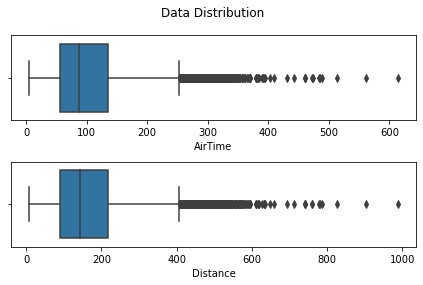

In [49]:
#Let's take a sample of our data and view the distribution of our variables
distribution_df = airline.sample(False, 0.3, seed=10).toPandas()

#View data distribution in subplots
fig, axes = plt.subplots(2, 1)
sns.boxplot(data=distribution_df, x='AirTime', ax=axes[0])
sns.boxplot(data=distribution_df, x='Distance', ax=axes[1])
fig.suptitle('Data Distribution')
plt.tight_layout()
plt.show()
#Our data seems to have a lot of outliers so standardization over normalization is better

### b) Prepare data for ML, create KMeans Object and fit them our Flights Data.

In [50]:
#Instantiate preprocessors
vec_assembler = VectorAssembler(inputCols=['AirTime', 'Distance'], outputCol='features')
scaler = StandardScaler(inputCol='features', outputCol='features_scaled')

In [51]:
#Instantiate KMeans Object
km = KMeans(featuresCol = 'features_scaled', predictionCol = 'prediction', k = 5, seed=1)
#Instantiate Pipeline Object
km_pipeline = Pipeline(stages=[vec_assembler, scaler, km])

In [52]:
#Fit Model and Score
km_model = km_pipeline.fit(airline)

#Score
predictions = km_model.transform(airline)
km_evaluator = ClusteringEvaluator()
#Get Silhouette Score 
km_evaluator.evaluate(predictions)

0.7167943363348167

### c) Optimize our model using hyperparameter tuning.

In [53]:
#Optimize our model using hyperparameter tuning

#Build Param Grid
grid = tune.ParamGridBuilder()
grid = grid.addGrid(km.k, [3, 4, 5, 6, 7])
grid = grid.build()

#Instantiate Cross-Validator
cv = tune.CrossValidator(estimator=km_pipeline, estimatorParamMaps=grid, evaluator=km_evaluator, numFolds=4)



In [54]:
#Fit model & extract best model
models = cv.fit(airline)
best_model = models.bestModel

In [55]:
print(best_model.stages[2])
#Use info from above to index model's best score
print('Best Silhouette Score:', models.avgMetrics[0])

KMeansModel: uid=KMeans_bf7cc302aeda, k=3, distanceMeasure=euclidean, numFeatures=2
Best Silhouette Score: 0.7560161229210949


### d) Visualize our clusters.

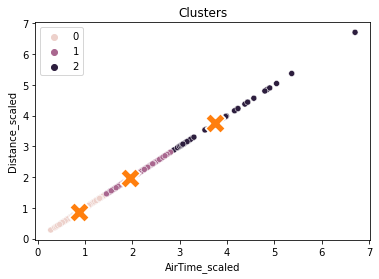

In [56]:
#Retrieve centroids and convert to numpy array
cluster_centers = np.array(best_model.stages[2].clusterCenters())
predictions = best_model.transform(airline)
predictions = predictions.select('features_scaled','prediction')

#Data is large so we will sample 1%
cluster_df = predictions.sample(False, 0.01, seed=10).toPandas()

#Must retrieve datapoints in scaled (as centroids are scaled)
cluster_df['AirTime_scaled'] = [x[0] for x in cluster_df.features_scaled]
cluster_df['Distance_scaled'] = [x[1] for x in cluster_df.features_scaled]

#Plot Clusters with Centroid Markers
sns.scatterplot(data=cluster_df, x='AirTime_scaled', y='Distance_scaled', hue='prediction')
sns.scatterplot(x=cluster_centers[:,0], y=cluster_centers[:, 1], marker='X', s=400)
plt.title('Clusters')
plt.show()

In [ ]:
#Export new csv & close sparksession
airline.write.csv("Data/airline.csv")

### e) Push our predictions dataframe into a mySQL database.

In [ ]:
#Instantiate SQL Cursor
conn_object = mysql.connector.connect(host='localhost', user='root', password='')
cursor = conn_object.cursor()

#Use Cursor to create a DB in mySQL #In Try/Except statement for re-running of code
try:
    cursor.execute("CREATE DATABASE flights")
except:
    cursor.execute("DROP DATABASE flights")
    cursor.execute("CREATE DATABASE flights")

In [ ]:
#Instantiate New Spark Session Configured for mySQL
spark = SparkSession.builder.config("spark.jars", "mysql-connector-java-8.0.28.jar").master("local[*]").appName('flights_mysql').getOrCreate()

In [ ]:
airline.write.format('jdbc').options(
      url='jdbc:mysql://localhost:3306/flights',
      driver='com.mysql.jdbc.Driver',
      dbtable='Airline',
      user='root',
      password='').mode('append').save()